<a href="https://colab.research.google.com/github/AlejandroSepulvedaGuatecique/Pandas_Exercise/blob/main/PWP_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Example using constrained GP model
This is the code used to produce the first example in the paper _'Gaussian processes with linear operator inequality constraints'_, https://arxiv.org/abs/1901.03134

In [1]:
!git clone https://github.com/cagrell/gp_plotly
!git clone https://github.com/cagrell/gp_constr
!pip install chart_studio
!pip install pyDOE

Cloning into 'gp_plotly'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 39 (delta 0), reused 2 (delta 0), pack-reused 35
Unpacking objects: 100% (39/39), done.
Cloning into 'gp_constr'...
remote: Enumerating objects: 207, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 207 (delta 0), reused 1 (delta 0), pack-reused 204
Receiving objects: 100% (207/207), 26.60 MiB | 29.97 MiB/s, done.
Resolving deltas: 100% (121/121), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 3.0 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=6cc88c6de61fee0675d0c8b994a7cc6c2b05fcf7dd4f941f3640b53b8033842c
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac

In [2]:
# Load R
%reload_ext rpy2.ipython
%config IPCompleter.greedy=True
%config InlineBackend.figure_format = 'retina'

In [3]:
# indicate that you're running R code
%%R

# Install if it's your first time to run
install.packages("tmvtnorm") 
install.packages("TruncatedNormal")
install.packages("truncnorm")




(as ‘lib’ is unspecified)





























	‘/tmp/RtmpKSmK0H/downloaded_packages’

(as ‘lib’ is unspecified)












































	‘/tmp/RtmpKSmK0H/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpKSmK0H/downloaded_packages’



### Imports

In [4]:
### Basic imports ###
import sys, os

# For plotting
from IPython.display import display, HTML

# This is for plotting as static images (to show on e.g. GitHub)
import plotly.io as pio
from IPython.display import Image

# Numerics
import numpy as np
import scipy as sp
import itertools
import pyDOE

### Custom files ###

dir_GPPlotly = '/content/gp_plotly'
sys.path.append(dir_GPPlotly) 

# Path to the constrained GP moule 
# can be downloaded at https://github.com/cagrell/gp_constr
dir_gp_constr = '/content/gp_constr'
sys.path.append(dir_gp_constr) 

# Import
from GPPlotly.plottingfunctions import PlotGP2d, add_traces_to_fig
from GPConstr.model import GPmodel, Constraint
from GPConstr.kern import kernel_RBF

### Setup notebook ###
print('Python version', sys.version)

Loading constrained GP module from /content


Loading R wrapper...





Attaching package: ‘TruncatedNormal’



    dtmvnorm, dtmvt, ptmvnorm, ptmvt, rtmvnorm, rtmvt



    pmvnorm, pmvt




Running R from rpy2: R version 4.2.1 (2022-06-23)
Python version 3.7.14 (default, Sep  8 2022, 00:06:44) 
[GCC 7.5.0]


In [5]:
os.getcwd()
os.chdir('/content')

## 1. Define function for generating synthetic test/training data


In [41]:
import pandas as pd
import numpy as np
df_d = pd.read_excel('TABLE_PYTHON.xlsx') 
df_d.head()

y = df_d[['ru_end']]
X = df_d[['Qcr', 'AI','H']]
m = len(y)
n = np.size(X,1)
y = np.hstack((np.ones((m,1)),y))
X = np.hstack((np.ones((m,1)),X))
X = np.delete(X,[0],axis=1)
y = np.delete(y,[0],axis=1)
y = y.flatten()


Qcrmax = np.max(X[:,0])
Qcrmin = np.min(X[:,0])
X[:,0] = (X[:,0]-Qcrmin)/(Qcrmax-Qcrmin)
AImax = np.max(X[:,1])
AImin = np.min(X[:,1])
X[:,1] = (X[:,1]-AImin)/(AImax-AImin)
Hmax = np.max(X[:,2])
Hmin = np.min(X[:,2])
X[:,2] = (X[:,2]-Hmin)/(Hmax-Hmin)

Qcrmax_norm = np.max(X[:,0])
Qcrmin_norm = np.min(X[:,0])


AImax_norm = np.max(X[:,1])
AImin_norm = np.min(X[:,1])

Hmax_norm = np.max(X[:,2])
Hmin_norm = np.min(X[:,2])
n_plot = 20
Qcr_plot = np.linspace(Qcrmin_norm, Qcrmax_norm, n_plot)
AI_plot = np.linspace(AImin_norm, AImax_norm, n_plot)
H_plot = np.linspace(Hmin_norm, Hmax_norm, n_plot)

X_train = X
y_train = y

## 2. Regression with Gaussian noise

### 2.2. Define GP model (without constraints)

In [44]:
# Set up model
ker = kernel_RBF(variance = 0.2, lengthscale = [0.7, 0.6, 0.2 ])
model = GPmodel(kernel = ker, likelihood = 0.3, mean = 0) 

# Add the training data
model.X_training = X_train

model.Y_training = y_train
print(model)

----- GP model ----- 
 mean = 0 
 likelihood = 0.3 
 kernel: 
   type = RBF 
   input dim = 3 
   lenghtscale = [0.7 0.6 0.2] 
   variance = 0.2 
 constraint: 
   No constraints 
---------------------


In [43]:
# Optimize hyperparameters
model.optimize(include_constraint = False, fix_likelihood = False)
print(model)

..Running optimization for unconstrained GP ... DONE - Total time: 0.334 seconds
----- GP model ----- 
 mean = 0 
 likelihood = 0.047640620678086276 
 kernel: 
   type = RBF 
   input dim = 3 
   lenghtscale = [0.69034217 0.59961549 0.26141149] 
   variance = 0.1578048050631056 
 constraint: 
   No constraints 
---------------------


In [45]:
X, Y = np.meshgrid(AI_plot, H_plot)
Dr65 = 0.5*(np.ones((n_plot,1)))
xy = np.column_stack((Dr65,X[:,0],Y[:,0]))
Z_mean, Z_var = model.calc_posterior_unconstrained(xy, full_cov = True)
Z_std = np.diagonal(Z_var)
for i in range(1,X.shape[1]):
      print(i)
      xy = np.column_stack((Dr65,X[:,i],Y[:,i]))
      z_mean, z_var = model.calc_posterior_unconstrained(xy, full_cov = True)
      z_std = np.diagonal(Z_var)
      Z_mean = np.column_stack((Z_mean,z_mean))
      Z_std = np.column_stack((Z_std,z_std))





..Running calculation of K_w ... DONE - time: 0.001 seconds
..Running calculation of Cholesky factor for K_w ... DONE - time: 0.007 seconds
..Calculating f* | Y ... DONE - Total time: 0.010 seconds
1
..Running calculation of K_w ... SKIP - (cached)
..Running calculation of Cholesky factor for K_w ... SKIP - (cached)
..Calculating f* | Y ... DONE - Total time: 0.002 seconds
2
..Running calculation of K_w ... SKIP - (cached)
..Running calculation of Cholesky factor for K_w ... SKIP - (cached)
..Calculating f* | Y ... DONE - Total time: 0.001 seconds
3
..Running calculation of K_w ... SKIP - (cached)
..Running calculation of Cholesky factor for K_w ... SKIP - (cached)
..Calculating f* | Y ... DONE - Total time: 0.001 seconds
4
..Running calculation of K_w ... SKIP - (cached)
..Running calculation of Cholesky factor for K_w ... SKIP - (cached)
..Calculating f* | Y ... DONE - Total time: 0.001 seconds
5
..Running calculation of K_w ... SKIP - (cached)
..Running calculation of Cholesky facto

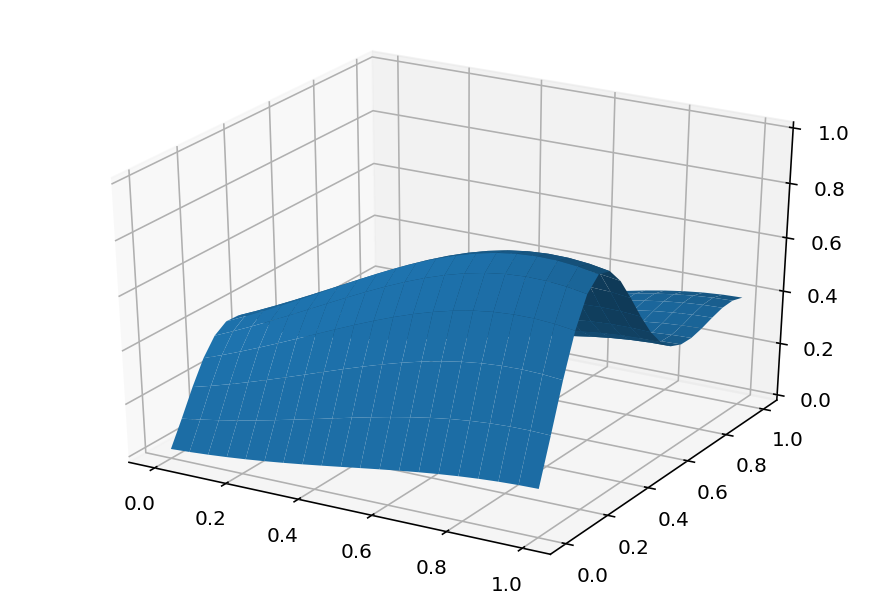

In [46]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)

surf = ax.plot_surface(X,Y,Z_mean)
ax.set_zlim([0,1])
plt.show()



0.4354182750728828
..Running calculation of K_w ... SKIP - (cached)
..Running calculation of Cholesky factor for K_w ... SKIP - (cached)
..Calculating f* | Y ... DONE - Total time: 0.003 seconds


(0.0, 1.2)

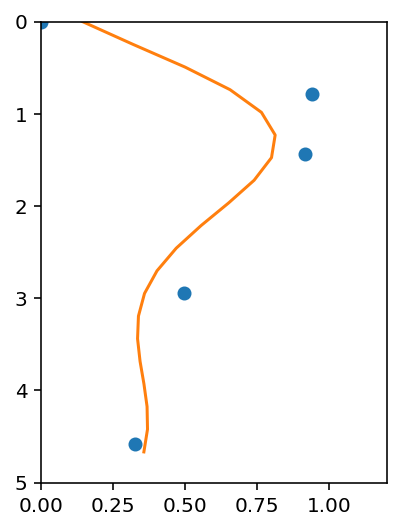

In [47]:
df1 = (df_d['Qcr']-Qcrmin)/(Qcrmax-Qcrmin)
df2 = (df_d['AI']-AImin)/(AImax-AImin)
df3 = (df_d['H']-Hmin)/(Hmax-Hmin)
df4 = df_d['ru_end']
df0 = df_d['Label']
DF = pd.concat([df0,df1,df2,df3,df4], axis=1, join='inner')

bol = DF['Label'] == "RPI10"
RPI10 = DF[bol]
print(RPI10['Qcr'].iat[0])

X, Y = np.meshgrid(AI_plot, H_plot)
Dr_exp = RPI10['Qcr'].iat[0]*(np.ones((n_plot,1)))
AI_exp = RPI10['AI'].iat[0]*(np.ones((n_plot,1)))

xy = np.column_stack((Dr_exp,AI_exp,H_plot))
Z_mean, Z_var = model.calc_posterior_unconstrained(xy, full_cov = True)
Z_std = np.diagonal(Z_var)


fig = plt.figure()
axes = fig.add_axes([0.1,0.1,0.4,0.8])
axes.plot(RPI10['ru_end'],RPI10['H']*(Hmax-Hmin)+Hmin,'o')
axes.plot(Z_mean,H_plot*(Hmax-Hmin)+Hmin)
plt.ylim(5, 0)
plt.xlim(0, 1.2)

### 2.2.3. Include constraints (boundedness and monotonicity)

In [72]:
# Helper functions for constraints
def constant_function(val):
    """ Return the constant function"""
    def fun(x):
        return np.array([val]*x.shape[0])
    
    return fun

def fun_UB(x):
    """ Upper bound function """
    #return (np.exp(x[:,2].flatten())-1) + 0.001
    return  np.tanh(10*x[:,2].flatten())
def fun_LB(x):
    """ Upper bound function """
    #return -1*(np.exp(x[:,2].flatten())-1) - 0.001
    return  -1*np.tanh(10*x[:,2].flatten())


In [73]:
# Define constraints for bounding the function and its derivative
constr_bounded = Constraint(LB = fun_LB, UB = fun_UB)
#constr_deriv = Constraint(LB = constant_function(0), UB = constant_function(float('Inf')))

In [74]:
# Add constraints to model
model.constr_bounded = constr_bounded
#model.constr_deriv = [constr_deriv] # Add list of constraints for multi-dimensional functions
model.constr_likelihood = 0.001

print(model)


----- GP model ----- 
 mean = 0 
 likelihood = 0.3 
 kernel: 
   type = RBF 
   input dim = 3 
   lenghtscale = [0.7 0.6 0.2] 
   variance = 0.2 
 constraint: 
   f [0] 
   constr_likelihood = 0.001 
---------------------


In [75]:
Omega = np.random.uniform(size = (1000, 3))
df, num_pts, pc_min = model.find_XV_subop(p_target = 0.9, Omega = Omega, sampling_alg = 'minimax_tilting', num_samples = 10,
                         max_iterations = 1, print_intermediate = False)

# Then we run multiple iterations with p_target = 0.7 
Omega = np.random.uniform(size = (1000, 3)) # Candidate set
df, num_pts, pc_min = model.find_XV_subop(p_target = 0.9, Omega = Omega, sampling_alg = 'minimax_tilting', num_samples = 10,
                         max_iterations = 50, print_intermediate = False)

model.constrprob_Xv(n = 1000)


Searching for points XV s.t. P(a - nu < Lf < b + nu) > p_target = 0.9 for Lf = [f] and nu = 0.0012815515655446004 ...
DONE - Found 1 points. Min. constraint prob = 0.01840285462311919. Total time spent = 0.065 seconds
Searching for points XV s.t. P(a - nu < Lf < b + nu) > p_target = 0.9 for Lf = [f] and nu = 0.0012815515655446004 ...
DONE - Found 45 points. Min. constraint prob = 0.9055939313168435. Total time spent = 2.080 seconds


4.858096896332386e-25

..Running calculation of K_w ... SKIP - (cached)
..Running calculation of Cholesky factor for K_w ... SKIP - (cached)
..Running preparation step 1 - dependence on (XS, X) ... DONE - time: 0.005 seconds
..Running preparation step 2 - dependence on (XV, X) ... SKIP - (cached)
..Running preparation step 3 - dependence on (XS, XV, X) ... DONE - time: 0.001 seconds
..using old samples from truncated constraint distribution C~|C, Y
..sampling 1000 times from constrained GP f*|C, Y DONE - time: 0.003 seconds
..computing statistics from samples DONE - time: 0.002 seconds
 DONE - Total time: 0.019 seconds


(-0.2, 1.2)

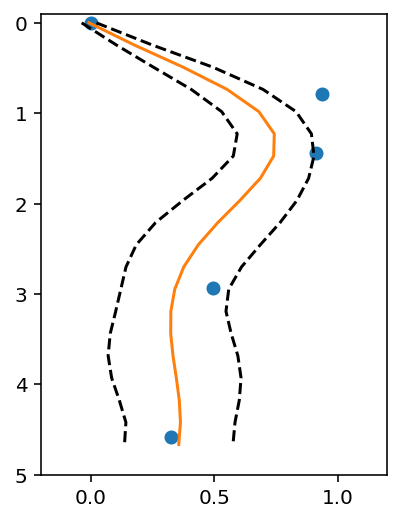

In [81]:
bol = DF['Label'] == "RPI10"
RPI10 = DF[bol]

X, Y = np.meshgrid(AI_plot, H_plot)
Dr_exp = RPI10['Qcr'].iat[0]*(np.ones((n_plot,1)))
AI_exp = RPI10['AI'].iat[0]*(np.ones((n_plot,1)))

xy = np.column_stack((Dr_exp,AI_exp,H_plot))
Z_mean, Z_var, perc, mode, samples, sampling_time  = \
model.calc_posterior_constrained(xy, compute_mode = False, num_samples = 1000, \
save_samples = 1, algorithm = 'minimax_tilting', resample = False)


fig = plt.figure()
axes = fig.add_axes([0.1,0.1,0.4,0.8])
axes.plot(RPI10['ru_end'],RPI10['H']*(Hmax-Hmin)+Hmin,'o')
axes.plot(Z_mean,H_plot*(Hmax-Hmin)+Hmin)
axes.plot(Z_mean+np.sqrt(Z_var),H_plot*(Hmax-Hmin)+Hmin,'--k')
axes.plot(Z_mean-np.sqrt(Z_var),H_plot*(Hmax-Hmin)+Hmin,'--k')

plt.ylim(5, -0.1)
plt.xlim(-0.2, 1.2)

In [ ]:
print(np.sqrt(Z_var))

In [83]:
print(model)

----- GP model ----- 
 mean = 0 
 likelihood = 0.3 
 kernel: 
   type = RBF 
   input dim = 3 
   lenghtscale = [0.7 0.6 0.2] 
   variance = 0.2 
 constraint: 
   f [46] 
   constr_likelihood = 0.001 
---------------------


In [78]:
X, Y = np.meshgrid(AI_plot, H_plot)
Dr65 = 0.7*(np.ones((n_plot,1)))
xy = np.column_stack((Dr65,X[:,0],Y[:,0]))
Z_mean, Z_var, perc, mode, samples, sampling_time  = \
model.calc_posterior_constrained(xy, compute_mode = False, num_samples = 1000, \
save_samples = 30, algorithm = 'minimax_tilting', resample = False)

for i in range(1,X.shape[1]):
      print(i)
      xy = np.column_stack((Dr65,X[:,i],Y[:,i]))
      z_mean, z_var, perc, mode, samples, sampling_time  = \
      model.calc_posterior_constrained(xy, compute_mode = False, num_samples = 1000, \
      save_samples = 30, algorithm = 'minimax_tilting', resample = False)
      
      Z_mean = np.column_stack((Z_mean,z_mean))
      Z_var = np.column_stack((Z_var,z_var))





..Running calculation of K_w ... SKIP - (cached)
..Running calculation of Cholesky factor for K_w ... SKIP - (cached)
..Running preparation step 1 - dependence on (XS, X) ... DONE - time: 0.008 seconds
..Running preparation step 2 - dependence on (XV, X) ... SKIP - (cached)
..Running preparation step 3 - dependence on (XS, XV, X) ... DONE - time: 0.001 seconds
..using old samples from truncated constraint distribution C~|C, Y
..sampling 1000 times from constrained GP f*|C, Y DONE - time: 0.007 seconds
..computing statistics from samples DONE - time: 0.004 seconds
 DONE - Total time: 0.020 seconds
1
..Running calculation of K_w ... SKIP - (cached)
..Running calculation of Cholesky factor for K_w ... SKIP - (cached)
..Running preparation step 1 - dependence on (XS, X) ... DONE - time: 0.002 seconds
..Running preparation step 2 - dependence on (XV, X) ... SKIP - (cached)
..Running preparation step 3 - dependence on (XS, XV, X) ... DONE - time: 0.001 seconds
..using old samples from trunca

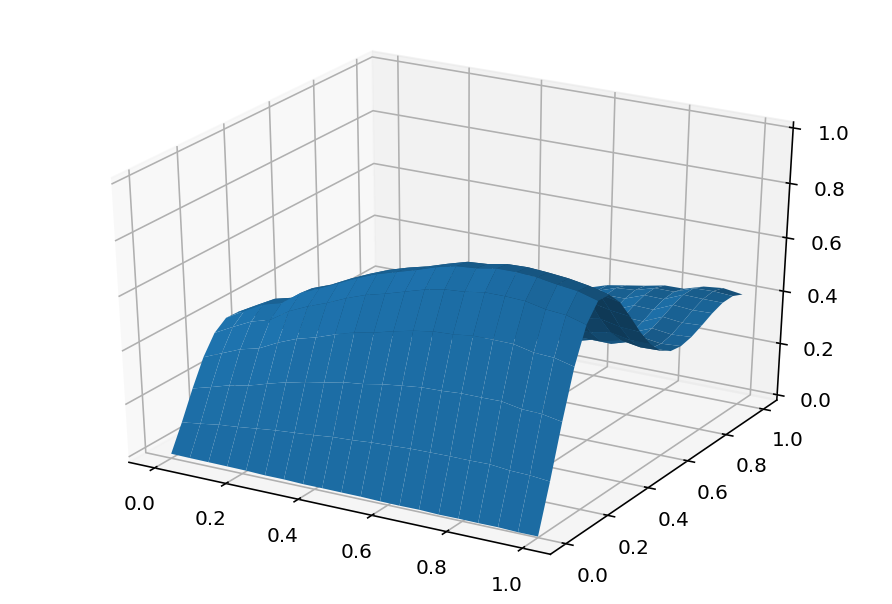

In [79]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)

surf = ax.plot_surface(X,Y,Z_mean)
ax.set_zlim([0,1])
plt.show()

